#### Prerequesites:
* Define schema (make figure) 
* Define structure (make figure)
* Define schema class in python (src/models/model_schemata.py)
* Convert schema + structure into model template (models/templates/p_model.pl)

#### Procedure:
* Load data
* Adjust model script for lfi accordingly
* Create evidence file (if I don't need different evidence files, move to builmodel notebook)
* LFI

1 single instance, 1 pst, 3 enzymes, all samples in one instance, test how many samples can be in one instance, how computing time depends on N p::f

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import random

from src.models import model_schemata as schema
from src.models import build_model as build
from src.visualization import visualize as viz

In [3]:
# os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

#### Training/Testing

In [4]:
# reading csv from files into dict
data = {}
data['e_activity'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/e_activity.csv')
data['p_occupancy'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/p_occupancy.csv')
data['e_activity']

,enzyme,sample,value,prob
0,e1,s1,inc,0.774553
1,e1,s10,dec,0.617971
2,e1,s100,inc,0.796040
3,e1,s11,base,0.650127
4,e1,s12,dec,0.748834
...,...,...,...,...
295,e3,s95,inc,0.644811
296,e3,s96,inc,0.550137
297,e3,s97,inc,0.812202
298,e3,s98,dec,0.783041


Splitting data into training/testing

In [49]:
# getting sample names (union of all samples in all datasets)
samples = list(set(data['e_activity']['sample']).union(set(data['p_occupancy']['sample'])))
samples.sort()
# sample x% of samples randomly without replacement with seed
random.seed(613)
train = random.sample(samples, int(len(samples)*0.02))
# train = ['s40', 's23', 's22', 's99', 's7', 's61', 's62', 's63']
# filter data
training_data = {}
training_data['e_activity'] = data['e_activity'][data['e_activity']['sample'].isin(train)].reset_index(drop=True)
training_data['p_occupancy'] = data['p_occupancy'][data['p_occupancy']['sample'].isin(train)].reset_index(drop=True)
print(train)

['s40', 's23']


In [50]:
# Mapping data to Problog predicates
predicates = {}
predicates['e_ksea'] = schema.EKseaPredicate()
predicates['e_ksea'].add_data(training_data['e_activity'], 'enzyme', 'sample', 'value')
predicates['p_fc'] = schema.PFoldChangePredicate()
predicates['p_fc'].add_data(training_data['p_occupancy'], 'phosphosite', 'sample', 'value')

In [51]:
evidence = []
for predicate in predicates:
    evid_generator = build.ProblogStatementGenerator(predicates[predicate])
    evidence = evidence + evid_generator.generate_facts(build.EvidenceTemplate)
evidence[:10]

['evidence(e_ksea(e1, s23, inc)).',
 'evidence(e_ksea(e1, s40, base)).',
 'evidence(e_ksea(e2, s23, base)).',
 'evidence(e_ksea(e2, s40, dec)).',
 'evidence(e_ksea(e3, s23, dec)).',
 'evidence(e_ksea(e3, s40, base)).',
 'evidence(p_fc(p0, s23, inc)).',
 'evidence(p_fc(p0, s40, dec)).']

In [52]:
# write evidence to text file
with open('models/synthetic_data/toy_network_mini/p_model/evidence_o1.pl', 'w') as f:
    for item in evidence:
        f.write("%s\n" % item)

LFI

In [48]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
max_iter = 3
# learning from interpretation
cmd = f'problog lfi {DIR}p_model_lfi_o1.pl {DIR}evidence_o1.pl -O {DIR}p_model_o1.pl -k ddnnf -v -n {max_iter}'
os.system(cmd)

[INFO] Output level: INFO
[INFO] Number of examples: 1
[INFO] Compile time: 1.087922
[INFO] Weights to learn: [t(0.33,E,S)::e_ksea(E,S,dec), t(0.33,E,S)::e_ksea(E,S,base), t(0.33,E,S)::e_ksea(E,S,inc), t(0.33,P,S)::p_fc(P,S,dec), t(0.33,P,S)::p_fc(P,S,base), t(0.33,P,S)::p_fc(P,S,inc), t(0.33,E,S)::e_activity(E,S,dec), t(0.33,E,S)::e_activity(E,S,base), t(0.33,E,S)::e_activity(E,S,inc), t(0.7,E,P)::occ_dec(P,S), t(0.7,E,P)::occ_dec(P,S), t(0.7,E,P)::occ_base(P,S), t(0.7,E,P)::occ_base(P,S), t(0.7,E,P)::occ_inc(P,S), t(0.7,E,P)::occ_inc(P,S), t(1.0)::p_occupancy(P,S,dec), t(0.0)::p_occupancy(P,S,base), t(0.0)::p_occupancy(P,S,inc), t(0.0)::p_occupancy(P,S,dec), t(0.0)::p_occupancy(P,S,base), t(1.0)::p_occupancy(P,S,inc), t(0.25)::p_occupancy(P,S,dec), t(0.5)::p_occupancy(P,S,base), t(0.25)::p_occupancy(P,S,inc), t(0.0)::p_occupancy(P,S,dec), t(1.0)::p_occupancy(P,S,base), t(0.0)::p_occupancy(P,S,inc), t(1.0)::p_occupancy(P,S,dec), t(0.0)::p_occupancy(P,S,base), t(0.0)::p_occupancy(P,S,i

0

In [53]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
# learning from interpretation
cmd = f'problog ground {DIR}p_model_lfi_o1.pl -o {DIR}p_model_o1_ground.pl --format pl'
os.system(cmd)

(True, 't(0.33,e1,s23)::e_activity(e1,s23,base); t(0.33,e1,s23)::e_activity(e1,s23,dec); t(0.33,e1,s23)::e_activity(e1,s23,inc).\n0.0081052572::e_ksea(e1,s23,inc) :- e_activity(e1,s23,base).\n0.001::e_ksea(e1,s23,inc) :- e_activity(e1,s23,dec).\n0.9827894856::e_ksea(e1,s23,inc) :- e_activity(e1,s23,inc).\nt(0.33,e1,s23)::e_ksea(e1,s23,inc).\nt(0.33,e1,s40)::e_activity(e1,s40,base); t(0.33,e1,s40)::e_activity(e1,s40,dec); t(0.33,e1,s40)::e_activity(e1,s40,inc).\n0.9053721692::e_ksea(e1,s40,base) :- e_activity(e1,s40,base).\n0.0846278308::e_ksea(e1,s40,base) :- e_activity(e1,s40,dec).\n0.0846278308::e_ksea(e1,s40,base) :- e_activity(e1,s40,inc).\nt(0.33,e1,s40)::e_ksea(e1,s40,base).\nt(0.33,e2,s23)::e_activity(e2,s23,base); t(0.33,e2,s23)::e_activity(e2,s23,dec); t(0.33,e2,s23)::e_activity(e2,s23,inc).\n0.8093256547::e_ksea(e2,s23,base) :- e_activity(e2,s23,base).\n0.1806743453::e_ksea(e2,s23,base) :- e_activity(e2,s23,dec).\n0.1806743453::e_ksea(e2,s23,base) :- e_activity(e2,s23,inc).\n

256

In [58]:
# DONE add to csv file for model training
n_samples = np.array([1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 50, 80])
n_evidence = np.array([4, 8, 12, 16, 20, 24, 28, 32, 40, 80, 200, 320])
n_pfacts = np.array([36, 72, 108, 144, 180, 216, 252, 288, 360, 720, 1800, 2880])
n_pfacts_e = np.array([40, 80, 120, 160, 200, 240, 280, 320, 400, 800, 2000, 3200])
n_params = np.array([58, 116, 174, 232, 290, 348, 406, 464, 580, 1160, 2900, 4640])
n_pfacts_cross = np.array([17, 34, 51, 68, 85, 102, 119, 136, 170, 340, 850, 1360])
n_params_cross = np.array([33, 66, 99, 132, 165, 198, 231, 264, 330, 660, 1650, 2640])
t_compile = np.array([0.442880, 0.558732, 0.627934, 0.658875, 0.790379, 0.803066, 0.857063, 1.002800, 1.084858, 2.078962, 5.165253, 9.420139])
t_total = np.array([1.2, 3.3, 7.0, 11.1, 16.7, 24.8, 35.0, 45.4, 66.4])

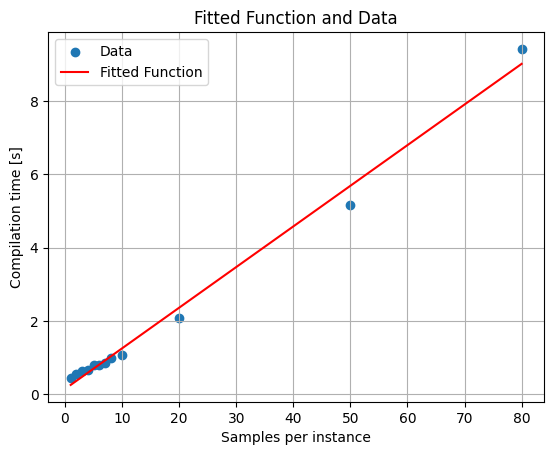

Predicted y-value for x = 80: 9.012566321636001s = 0.15020943869393336min = 0.002503490644898889h


In [59]:
viz.plot_time_lin(n_samples, t_compile, 'Samples per instance', 'Compilation time [s]', 80)

n_pfacts - Predicted y-value for x = 400: 1.3788970343972045s = 0.022981617239953407min = 0.00038302695399922344h
n_pfacts_e - Predicted y-value for x = 400: 1.2557733362272185s = 0.020929555603786974min = 0.0003488259267297829h
n_params - Predicted y-value for x = 400: 0.9118761103039744s = 0.015197935171732907min = 0.0002532989195288818h


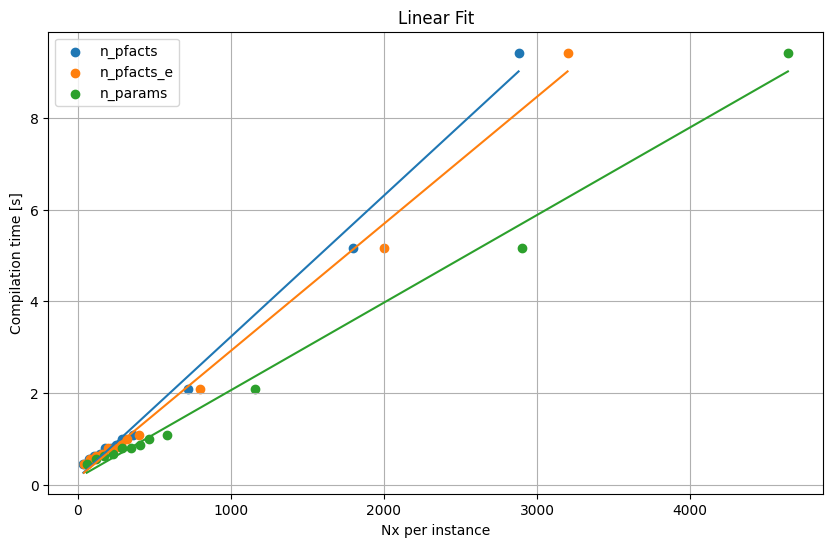

In [60]:
x_features = {'n_pfacts': n_pfacts, 'n_pfacts_e': n_pfacts_e, 'n_params': n_params}
y_time = {'n_pfacts': t_compile, 'n_pfacts_e': t_compile, 'n_params': t_compile}
viz.plot_multiple_time_lin(x_features, y_time, 'Nx per instance', 'Compilation time [s]', 400)

n_pfacts - Predicted y-value for x = 200: 19.883134505779566s = 0.3313855750963261min = 0.005523092918272102h
n_pfacts_e - Predicted y-value for x = 200: 15.85197258318505s = 0.2641995430530842min = 0.004403325717551403h
n_params - Predicted y-value for x = 200: 8.418552919388636s = 0.14030921532314394min = 0.002338486922052399h


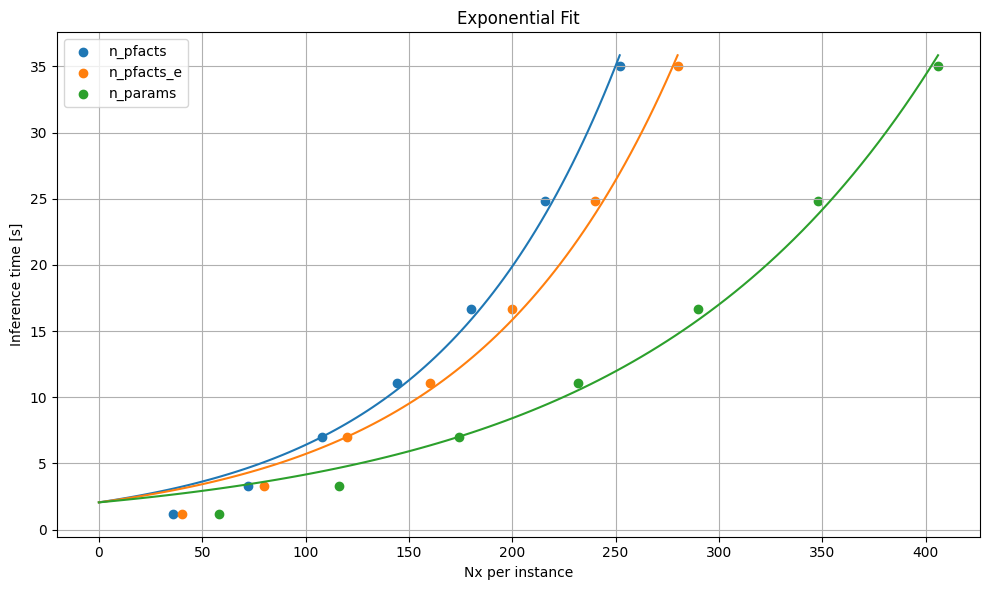

In [72]:
x_features = {'n_pfacts': n_pfacts[:7], 'n_pfacts_e': n_pfacts_e[:7], 'n_params': n_params[:7]}
y_time = {'n_pfacts': t_total[:7], 'n_pfacts_e': t_total[:7], 'n_params': t_total[:7]}
viz.plot_multiple_time_exp(x_features, y_time, 'Nx per instance', 'Inference time [s]', 200)

Part 2: Use e_activity and p_occupancy as evidence instead of e_ksea and p_fc

In [83]:
# getting sample names (union of all samples in all datasets)
samples = list(set(data['e_activity']['sample']).union(set(data['p_occupancy']['sample'])))
samples.sort()
# sample x% of samples randomly without replacement with seed
random.seed(613)
train = random.sample(samples, int(len(samples)*0.8))
# train = ['s40', 's23', 's22', 's99', 's7', 's61', 's62', 's63']
# filter data
training_data = {}
training_data['e_activity'] = data['e_activity'][data['e_activity']['sample'].isin(train)].reset_index(drop=True)
training_data['p_occupancy'] = data['p_occupancy'][data['p_occupancy']['sample'].isin(train)].reset_index(drop=True)
print(train)

['s40', 's23', 's22', 's7', 's61', 's62', 's63', 's10', 's2', 's75', 's67', 's52', 's93', 's47', 's21', 's77', 's58', 's85', 's68', 's92', 's84', 's83', 's56', 's72', 's87', 's11', 's89', 's64', 's82', 's29', 's59', 's1', 's70', 's39', 's12', 's5', 's99', 's94', 's48', 's28', 's80', 's34', 's17', 's91', 's54', 's45', 's15', 's50', 's32', 's76', 's69', 's81', 's49', 's25', 's38', 's74', 's41', 's42', 's86', 's30', 's96', 's97', 's16', 's36', 's71', 's14', 's57', 's20', 's88', 's53', 's90', 's19', 's6', 's3', 's37', 's27', 's43', 's66', 's8', 's4']


In [84]:
# Mapping data to Problog predicates
predicates = {}
predicates['e_activity'] = schema.EActivityPredicate()
predicates['e_activity'].add_data(training_data['e_activity'], 'enzyme', 'sample', 'value')
predicates['p_occupancy'] = schema.POccupancyPredicate()
predicates['p_occupancy'].add_data(training_data['p_occupancy'], 'phosphosite', 'sample', 'value')

In [85]:
evidence = []
for predicate in predicates:
    evid_generator = build.ProblogStatementGenerator(predicates[predicate])
    evidence = evidence + evid_generator.generate_facts(build.EvidenceTemplate)
evidence[:10]

['evidence(e_activity(e1, s1, inc)).',
 'evidence(e_activity(e1, s10, dec)).',
 'evidence(e_activity(e1, s11, base)).',
 'evidence(e_activity(e1, s12, dec)).',
 'evidence(e_activity(e1, s14, base)).',
 'evidence(e_activity(e1, s15, dec)).',
 'evidence(e_activity(e1, s16, base)).',
 'evidence(e_activity(e1, s17, base)).',
 'evidence(e_activity(e1, s19, dec)).',
 'evidence(e_activity(e1, s2, inc)).']

In [86]:
# write evidence to text file
with open('models/synthetic_data/toy_network_mini/p_model/evidence_o1.pl', 'w') as f:
    for item in evidence:
        f.write("%s\n" % item)

LFI

In [87]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
max_iter = 3
# learning from interpretation
cmd = f'problog lfi {DIR}p_model_lfi_o1.pl {DIR}evidence_o1.pl -O {DIR}p_model_o1.pl -k ddnnf -v -n {max_iter}'
os.system(cmd)

[INFO] Output level: INFO
[INFO] Number of examples: 1
[INFO] Compile time: 4.037163
[INFO] Weights to learn: [t(_,E,S)::e_ksea(E,S,dec), t(_,E,S)::e_ksea(E,S,base), t(_,E,S)::e_ksea(E,S,inc), t(_,P,S)::p_fc(P,S,dec), t(_,P,S)::p_fc(P,S,base), t(_,P,S)::p_fc(P,S,inc), t(0.33,E,S)::e_activity(E,S,dec), t(0.33,E,S)::e_activity(E,S,base), t(0.33,E,S)::e_activity(E,S,inc), t(0.7,E,P)::occ_dec(P,S), t(0.7,E,P)::occ_dec(P,S), t(0.7,E,P)::occ_base(P,S), t(0.7,E,P)::occ_base(P,S), t(0.7,E,P)::occ_inc(P,S), t(0.7,E,P)::occ_inc(P,S), t(1.0)::p_occupancy(P,S,dec), t(0.0)::p_occupancy(P,S,base), t(0.0)::p_occupancy(P,S,inc), t(0.0)::p_occupancy(P,S,dec), t(0.0)::p_occupancy(P,S,base), t(1.0)::p_occupancy(P,S,inc), t(0.25)::p_occupancy(P,S,dec), t(0.5)::p_occupancy(P,S,base), t(0.25)::p_occupancy(P,S,inc), t(0.0)::p_occupancy(P,S,dec), t(1.0)::p_occupancy(P,S,base), t(0.0)::p_occupancy(P,S,inc), t(1.0)::p_occupancy(P,S,dec), t(0.0)::p_occupancy(P,S,base), t(0.0)::p_occupancy(P,S,inc), t(0.0)::p_occ

Traceback (most recent call last):
  File "/home/mhuebner/anaconda3/envs/phospho_pi/lib/python3.11/site-packages/problog/learning/lfi.py", line 1544, in main
    results = run_lfi(program, examples, knowledge=knowledge, **options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mhuebner/anaconda3/envs/phospho_pi/lib/python3.11/site-packages/problog/learning/lfi.py", line 1371, in run_lfi
    score = lfi.run()
            ^^^^^^^^^
  File "/home/mhuebner/anaconda3/envs/phospho_pi/lib/python3.11/site-packages/problog/learning/lfi.py", line 984, in run
    score = self.step()
            ^^^^^^^^^^^
  File "/home/mhuebner/anaconda3/envs/phospho_pi/lib/python3.11/site-packages/problog/learning/lfi.py", line 951, in step
    results = self._evaluate_examples()
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mhuebner/anaconda3/envs/phospho_pi/lib/python3.11/site-packages/problog/learning/lfi.py", line 823, in _evaluate_examples
    result = evalua

256

In [123]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
# learning from interpretation
cmd = f'problog ground {DIR}p_model_lfi_o1.pl -o {DIR}p_model_o1_ground.pl --format pl'
os.system(cmd)

(True, 't(0.33,e1,s1)::e_activity(e1,s1,inc); t(0.33,e1,s1)::e_activity(e1,s1,dec); t(0.33,e1,s1)::e_activity(e1,s1,base).\nt(0.33,e1,s10)::e_activity(e1,s10,dec); t(0.33,e1,s10)::e_activity(e1,s10,base); t(0.33,e1,s10)::e_activity(e1,s10,inc).\nt(0.33,e1,s11)::e_activity(e1,s11,base); t(0.33,e1,s11)::e_activity(e1,s11,dec); t(0.33,e1,s11)::e_activity(e1,s11,inc).\nt(0.33,e1,s12)::e_activity(e1,s12,dec); t(0.33,e1,s12)::e_activity(e1,s12,base); t(0.33,e1,s12)::e_activity(e1,s12,inc).\nt(0.33,e1,s14)::e_activity(e1,s14,base); t(0.33,e1,s14)::e_activity(e1,s14,dec); t(0.33,e1,s14)::e_activity(e1,s14,inc).\nt(0.33,e1,s15)::e_activity(e1,s15,dec); t(0.33,e1,s15)::e_activity(e1,s15,base); t(0.33,e1,s15)::e_activity(e1,s15,inc).\nt(0.33,e1,s16)::e_activity(e1,s16,base); t(0.33,e1,s16)::e_activity(e1,s16,dec); t(0.33,e1,s16)::e_activity(e1,s16,inc).\nt(0.33,e1,s17)::e_activity(e1,s17,base); t(0.33,e1,s17)::e_activity(e1,s17,dec); t(0.33,e1,s17)::e_activity(e1,s17,inc).\nt(0.33,e1,s19)::e_acti

256

In [88]:
# DONE add to csv file for model training
n_samples_2 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 50, 80])
n_evidence_2 = np.array([4, 8, 12, 16, 20, 24, 28, 32, 40, 80, 200, 320])
n_pfacts_2 = np.array([20, 40, 60, 80, 100, 120, 140, 160, 200, 400, 1000, 1600])
n_pfacts_e_2 = np.array([24, 48, 72, 96, 120, 144, 168, 192, 240, 480, 1200, 1920])
n_params_2 = np.array([26, 52, 78, 104, 130, 156, 182, 208, 260, 520, 1300, 2080])
n_pfacts_cross_2 = np.array([17, 34, 51, 68, 85, 102, 119, 136, 170, 340, 850, 1360])
n_params_cross_2 = np.array([17, 34, 51, 68, 85, 102, 119, 136, 170, 340, 850, 1360])
t_compile_2 = np.array([0.453068, 0.482949, 0.482949, 0.528567, 0.611676, 0.646754, 0.707257, 0.710728, 0.797557, 1.209600, 2.593071, 4.010592])
t_total_2 = np.array([0.8, 1.6, 3.2, 5.9, 8.0, 11.0, 14.8, 19.8, 29.6, 115.3, 709.5])

n_samples - Predicted y-value for x = 100: 11.22879288865261s = 0.18714654814421017min = 0.003119109135736836h
n_samples_2 - Predicted y-value for x = 100: 4.880157374634177s = 0.08133595624390294min = 0.0013555992707317158h


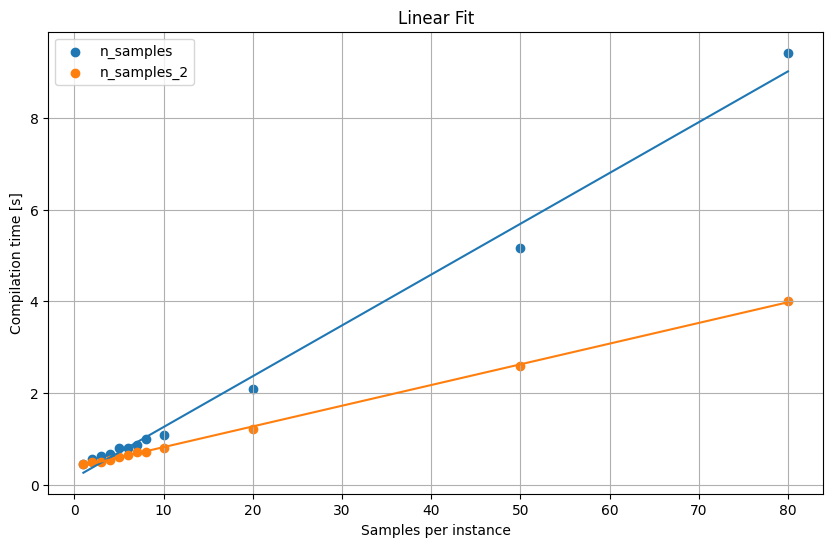

In [89]:
x_features = {'n_samples': n_samples, 'n_samples_2': n_samples_2}
y_time = {'n_samples': t_compile, 'n_samples_2': t_compile_2}
viz.plot_multiple_time_lin(x_features, y_time, 'Samples per instance', 'Compilation time [s]', 100)

n_samples - Predicted y-value for x = 100: 4461316495406.64s = 74355274923.444min = 1239254582.0574h
n_samples_2 - Predicted y-value for x = 100: 1371849629060.9922s = 22864160484.34987min = 381069341.40583116h


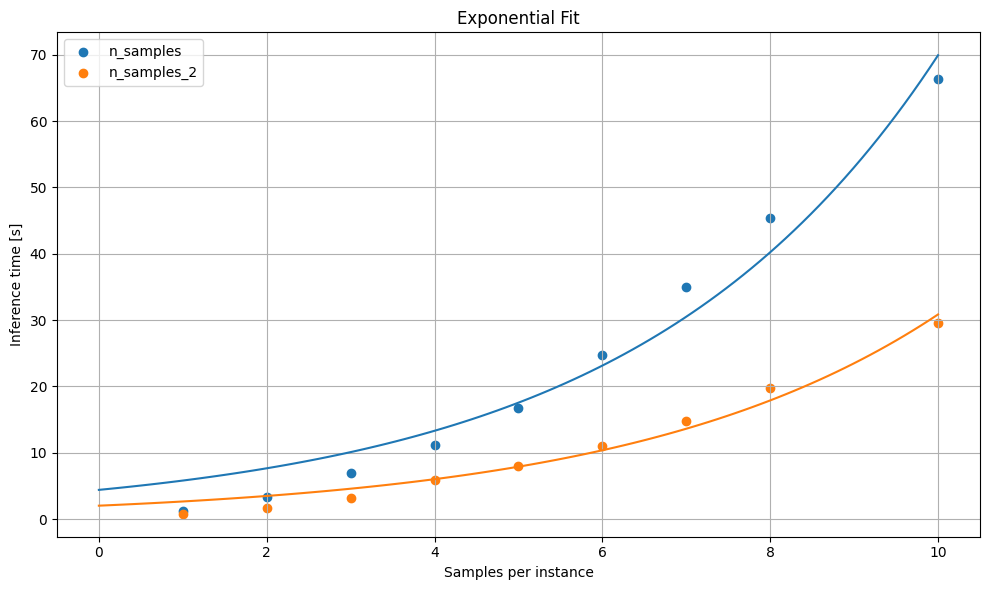

In [96]:
x_features = {'n_samples': n_samples[:9], 'n_samples_2': n_samples_2[:9]}
y_time = {'n_samples': t_total, 'n_samples_2': t_total_2[:9]}
viz.plot_multiple_time_exp(x_features, y_time, 'Samples per instance', 'Inference time [s]', 100)

n_pfacts - Predicted y-value for x = 400: 1.3788970343972045s = 0.022981617239953407min = 0.00038302695399922344h
n_pfacts_e - Predicted y-value for x = 400: 1.2557733362272185s = 0.020929555603786974min = 0.0003488259267297829h
n_params - Predicted y-value for x = 400: 0.9118761103039744s = 0.015197935171732907min = 0.0002532989195288818h
n_pfacts_2 - Predicted y-value for x = 400: 1.2684346259879324s = 0.021140577099798875min = 0.00035234295166331457h
n_pfacts_e_2 - Predicted y-value for x = 400: 1.1179461781190925s = 0.018632436301984873min = 0.00031054060503308124h
n_params_2 - Predicted y-value for x = 400: 1.0600660058661733s = 0.01766776676443622min = 0.00029446277940727033h


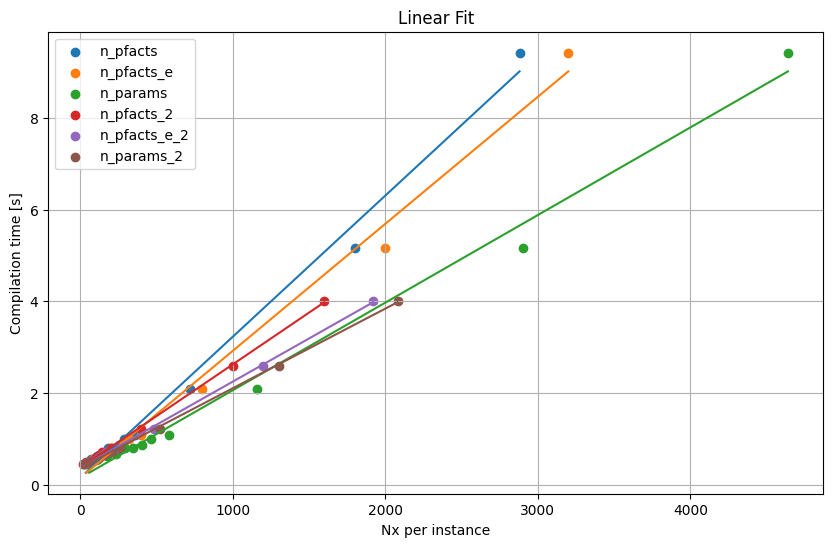

In [91]:
x_features = {'n_pfacts': n_pfacts, 'n_pfacts_e': n_pfacts_e, 'n_params': n_params,
              'n_pfacts_2': n_pfacts_2, 'n_pfacts_e_2': n_pfacts_e_2, 'n_params_2': n_params_2}
y_time = {'n_pfacts': t_compile, 'n_pfacts_e': t_compile, 'n_params': t_compile,
          'n_pfacts_2': t_compile_2, 'n_pfacts_e_2': t_compile_2, 'n_params_2': t_compile_2}
viz.plot_multiple_time_lin(x_features, y_time, 'Nx per instance', 'Compilation time [s]', 400)

n_pfacts - Predicted y-value for x = 400: 191.6465668931173s = 3.1941094482186214min = 0.05323515747031036h
n_pfacts_e - Predicted y-value for x = 400: 121.81409857475077s = 2.030234976245846min = 0.03383724960409744h
n_params - Predicted y-value for x = 400: 34.35626725573473s = 0.5726044542622455min = 0.009543407571037424h
n_pfacts_2 - Predicted y-value for x = 400: 470.37210305714945s = 7.839535050952491min = 0.13065891751587486h
n_pfacts_e_2 - Predicted y-value for x = 400: 189.70085547300005s = 3.1616809245500006min = 0.052694682075833346h
n_params_2 - Predicted y-value for x = 400: 133.77975000810738s = 2.229662500135123min = 0.03716104166891872h


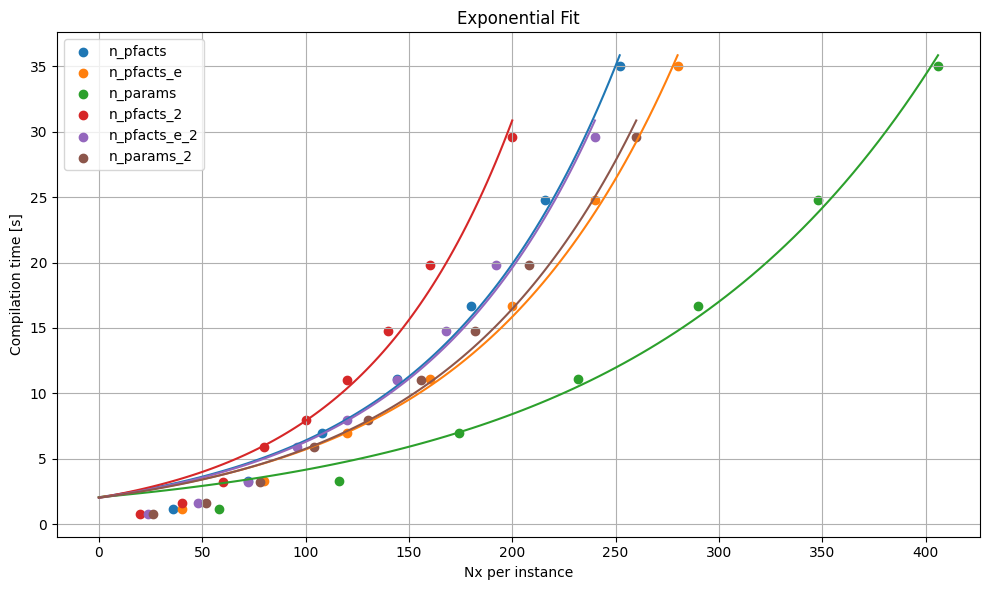

In [99]:
x_features = {'n_pfacts': n_pfacts[:7], 'n_pfacts_e': n_pfacts_e[:7], 'n_params': n_params[:7],
              'n_pfacts_2': n_pfacts_2[:9], 'n_pfacts_e_2': n_pfacts_e_2[:9], 'n_params_2': n_params_2[:9]}
y_time = {'n_pfacts': t_total[:7], 'n_pfacts_e': t_total[:7], 'n_params': t_total[:7],
          'n_pfacts_2': t_total_2[:9], 'n_pfacts_e_2': t_total_2[:9], 'n_params_2': t_total_2[:9]}
viz.plot_multiple_time_exp(x_features, y_time, 'Nx per instance', 'Compilation time [s]', 400)